**Modules**

In [58]:
# # Installs 
# !pip install pandas_datareader

import pandas as pd
import pandas_datareader as web
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    "font.size": 13,          # base font size
    "axes.labelsize": 13,     # x- and y-labels
    "axes.titlesize": 13,
    "xtick.labelsize": 13,
    "ytick.labelsize": 13,
    "legend.fontsize": 13,
})

**Reading Data**

In [59]:
# Path to final dataset
data_path = '/Users/jonas/Library/CloudStorage/OneDrive-UniversityofCopenhagen/Kandidat/Thesis/2.0 Data/Visualization/merged_data.parquet'

# Load the dataset
mkt = pd.read_parquet(data_path)

# # Display the first few rows of the dataframe
# mkt.head()

# Load dataset for SP500
sp500_mkt = pd.read_csv("/Users/jonas/Library/CloudStorage/OneDrive-UniversityofCopenhagen/Kandidat/Thesis/2.0 Data/SP500 MKTCAP/sp500_mktcap.csv")

In [60]:
# To datetime
sp500_mkt['date'] = pd.to_datetime(sp500_mkt['date'])

# Rename to date to mont and sp500_mkt
sp500_mkt.rename(columns={'date': 'month', 'sp500_market_cap_trillions': 'sp500_mktcap'}, inplace=True)

# Restrict from 2005-12-31 to 2021-12-31
sp500_mkt = sp500_mkt[(sp500_mkt['month'] >= '2005-12-31') & (sp500_mkt['month'] <= '2021-12-31')]

# Ensure month end
sp500_mkt['month'] = sp500_mkt['month'] + pd.offsets.MonthEnd(0)

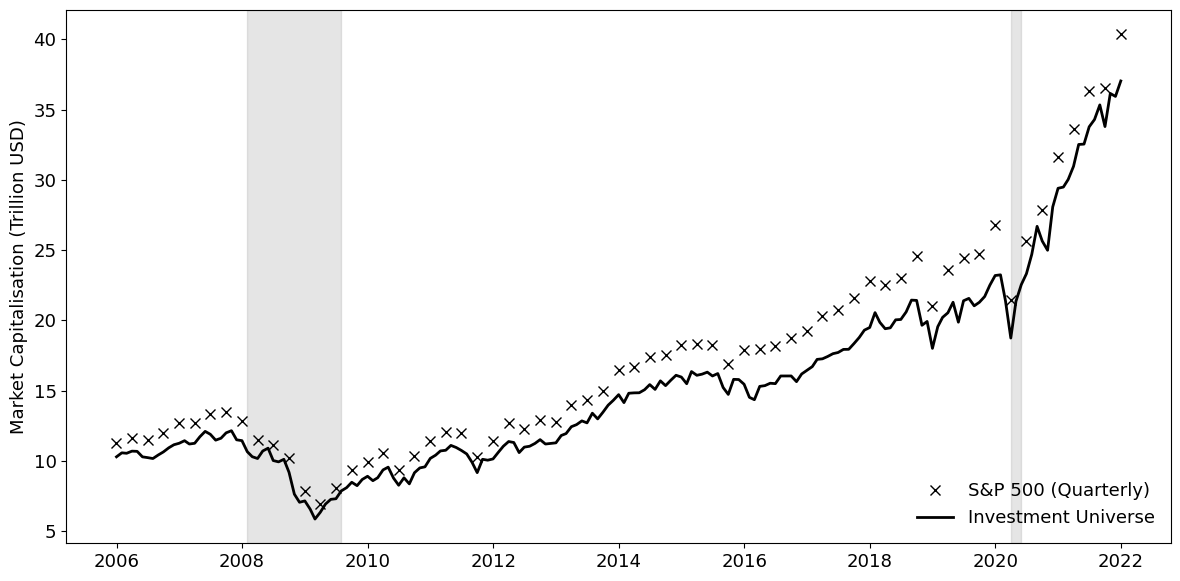

In [61]:
# Prepare monthly market cap (convert millions → trillions)
mkt["month"] = pd.to_datetime(mkt["month"])

mcap_col = "mktcap"

monthly_mcap = (
    mkt.groupby("month")[mcap_col]
       .sum()
       .sort_index()
       / 1e6
)

# Ensure SP500 data aligned
sp500_mkt["month"] = pd.to_datetime(sp500_mkt["month"])
sp500_mkt = sp500_mkt.set_index("month").sort_index()

# Load NBER recession data
recession = web.DataReader(
    "USREC",
    "fred",
    monthly_mcap.index.min(),
    monthly_mcap.index.max()
)

recession.index = pd.to_datetime(recession.index)
recession = recession.resample("ME").max()

# Identify recession periods
rec_periods = []
in_rec = False

for date, value in recession["USREC"].items():
    if value == 1 and not in_rec:
        in_rec = True
        start = date
    elif value == 0 and in_rec:
        in_rec = False
        end = date
        rec_periods.append((start, end))

if in_rec:
    rec_periods.append((start, recession.index.max()))

# Plot market capitalisation
fig, ax = plt.subplots(figsize=(12, 6))

for start, end in rec_periods:
    ax.axvspan(start, end, color="grey", alpha=0.2)

ax.plot(
    sp500_mkt.index,
    sp500_mkt["sp500_mktcap"],
    linestyle="none",
    marker="x",
    color="black",
    markersize=7,
    label="S&P 500 (Quarterly)"
)
ax.plot(
    monthly_mcap.index,
    monthly_mcap.values,
    linewidth=2,
    label="Investment Universe",
    color="black"
)

ax.set_ylabel("Market Capitalisation (Trillion USD)")

ax.ticklabel_format(style="plain", axis="y")
ax.legend(frameon=False, loc="lower right",)

plt.tight_layout()
plt.show()